In [ ]:
!pip install contractions

     |████████████████████████████████| 287 kB 4.4 MB/s 
     |████████████████████████████████| 106 kB 44.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas, re, contractions, nltk
from string import punctuation
from gensim.parsing.preprocessing import STOPWORDS
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
fakes = pandas.read_csv("./drive/MyDrive/Fake.csv")
fakes["label"] = 0

In [ ]:
reals = pandas.read_csv("./drive/MyDrive/True.csv")
reals["label"] = 1

In [ ]:
data = pandas.concat([fakes, reals], ignore_index=True)

In [ ]:
data["content"] = data["title"] + " " + data["text"]
data = data.drop(["title", "text"], axis=1)
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)

In [ ]:
columns = list(data.columns)

In [ ]:
def IsDatetime():
    result = []
    patt_mmddyyyy = "[a-z]*..[0-9]*..[0-9]*$"
    patt_ddmmyyyy = "[0-9]*..[a-z]*..[0-9]*$"
    for row in range(len(data)):
        if (re.match(patt_mmddyyyy, str(data.loc[row, 'date']).lower().strip())) or (re.match(patt_ddmmyyyy, str(data.loc[row, 'date']).lower().strip())):
            result.append(True)
        else:
            result.append(False)
    return result

In [ ]:
data = data.loc[IsDatetime()]
data = data.reset_index(drop=True)
data["date"] = pandas.to_datetime(data["date"])

In [ ]:
lemma = nltk.wordnet.WordNetLemmatizer()

In [ ]:
def RemoveWithPattern(patt_start, patt_end, text, replace_with):
  while True:
      start_ind = text.find(patt_start)
      if start_ind < 0:
          break
      else:
          end_ind = text.find(patt_end, start_ind)
          if end_ind < 0:
            end_ind = len(text)
          matched = text[start_ind: end_ind]
          text = text.replace(matched, replace_with)
  return text

# def ReplaceWithREPattern(patt, replace_with, text):
#   groups = re.search(patt, text)
#   for group in groups:
#     text.replace(group, replace_with)
#   return text

def RemoveNoneAlphaCharacter(text:str):
  lst = [text[i] for i in range(len(text))]
  result = []
  for char in lst:
    if char.isalpha():
      result.append(char)
  return "".join(result)

In [ ]:
# stopwords = nltk.corpus.stopwords.words("english")
# stopwords.remove("not")
stopwords = list(STOPWORDS)
stopwords.remove("not")

In [ ]:
with open("./drive/MyDrive/stopword_en.txt", 'w') as file:
  for i in range(len(stopwords)):
    file.write(stopwords[i] + '\n')

In [ ]:
# def fix(text: str):
#   text = contractions.fix(text).strip()
#   patt_textWithNum = "[0-9]+[a-zA-Z]"
#   for word in re.findall(patt, text):
#       text = text.replace(word, word[:-1] + " " + word[-1])
#   text = RemoveWithPattern("https", " ", text, "")
#   text = RemoveWithPattern("@", " ", text, "")
#   text = [lemma.lemmatize(word) for word in text.split()]
#   text = list(filter(lambda x: x.lower() not in stopwords, text))
#   text = " ".join(text)

#   return text
def fix(text):
  # Fix uncommon characters
  text = text.replace("’", "'")
  # Remove punctuations
  for punc in punctuation:
    text = text.replace(punc, "")

  # Fix number attach to text. Example: "2017no one likes you" usually happend with crawled comments from Twitter
  patt_textWithNum = "[0-9]+[a-zA-Z]"
  for group in set(re.findall(patt_textWithNum, text)):
    text = text.replace(group, group[:-1] + " " + group[-1])
  
  # Fix possesive case and NOT contraction come without ' char included
  patt_contraction = '[a-z|A-Z]* [t|s|d] '
  for group in set(re.findall(patt_contraction, text)):
    group = group.strip()
    text = text.replace(group, group.replace(" ", "'"))

  # Remove link and Twitter's tag
  text = RemoveWithPattern("https", " ", text, "")
  text = RemoveWithPattern("@", " ", text, "")

  text = contractions.fix(text)

  # Lemmatizing
  text = [lemma.lemmatize(word.strip()) for word in text.split()]
  result = []
  for t in text:
    if (t.lower() not in stopwords) and (t.isalpha):
      result.append(t)
  return result

In [ ]:
text = data.loc[0, 'content']
# text = text.replace("’", "'")
# groups = re.findall('[a-z|A-Z]* [t|s] ', text)
# for group in groups:
#   group = group.strip()
#   text = text.replace(group, group.replace(" ", "'"))
" ".join(fix(text))

In [ ]:
data["content"] = data["content"].apply(lambda x : " ".join(fix(x)))

In [ ]:
data['content'] = data['content'].apply(str.lower)

In [ ]:
embedding_vector_feature = 40
sent_len = 5000
voc_size = 10000

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
for label in [0, 1]:
    content = data.loc[data['label']==label]['content'].tolist()
    
    size_train = int(0.7 * len(content))
    X_train.extend(content[:size_train])
    y_train.extend([label for i in range(size_train)])
    
    size_val = int(0.2 * len(content))
    X_val.extend(content[size_train : ])
    y_val.extend([label for i in range(len(content)-size_train)])

    # X_test.extend(content[size_train+size_val:])
    # y_test.extend([label for i in range(len(content)-size_train-size_val)])

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train = [one_hot(text, voc_size) for text in X_train]
X_train = pad_sequences(X_train, padding='pre', maxlen=sent_len)

X_val = [one_hot(text, voc_size) for text in X_val]
X_val = pad_sequences(X_val, padding='pre', maxlen=sent_len)

X_test = [one_hot(text, voc_size) for text in X_test]
X_test = pad_sequences(X_test, padding='pre', maxlen=sent_len)

In [ ]:
import numpy
X_train = numpy.array(X_train)
y_train = numpy.array(y_train)
X_val = numpy.array(X_val)
y_val = numpy.array(y_val)
X_test = numpy.array(X_test)
y_test = numpy.array(y_test)

In [ ]:
import pickle
with open('./drive/MyDrive/TrainData.pkl', 'wb') as file:
    pickle.dump((X_train, y_train, X_val, y_val), file)
with open('./drive/MyDrive/TestData.pkl', 'wb') as file:
    pickle.dump((X_test, y_test), file)

In [ ]:
import pickle
with open("./drive/MyDrive/TrainData", "rb") as file:
  X_train, X_val, y_train, y_val = pickle.load(file)

In [ ]:
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.models import Sequential

In [ ]:
# LSTM model
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_feature, input_length=sent_len))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
# Bidirectional model
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=64))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation="relu"))
model.add(Dense(1))

In [ ]:
# Tensorflow model
model = Sequential()
model.add(Embedding(voc_size, sent_len))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
early_stop = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=3, mode="max", restore_best_weights=True)
# checkpoint = ModelCheckpoint("./drive/MyDrive/models//", "val_accuracy", save_best_only=True, save_weights_only=False, mode="max")

In [ ]:
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
# model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=64, callbacks=[early_stop])

Epoch 1/15
489/489 [==============================] - 5404s 11s/step - loss: 0.3223 - accuracy: 0.8285 - val_loss: 0.1099 - val_accuracy: 0.9676
Epoch 2/15
489/489 [==============================] - 5646s 12s/step - loss: 0.0405 - accuracy: 0.9905 - val_loss: 0.0891 - val_accuracy: 0.9817
Epoch 3/15
489/489 [==============================] - 5673s 12s/step - loss: 0.0200 - accuracy: 0.9961 - val_loss: 0.0563 - val_accuracy: 0.9867
Epoch 4/15
489/489 [==============================] - 5714s 12s/step - loss: 0.0218 - accuracy: 0.9939 - val_loss: 0.0719 - val_accuracy: 0.9826
Epoch 5/15
489/489 [==============================] - 5799s 12s/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.0530 - val_accuracy: 0.9889


In [ ]:
import json, time
old = {}
with open("./drive/MyDrive/models/bidirect/history.json", "a") as file:
  try:
    old = json.load(file)
  except:
    pass
  old.update({time.time() : history.history})
  json.dump(old, file)

In [ ]:
model.save("./drive/MyDrive/models/bidirect/")

INFO:tensorflow:Assets written to: ./drive/MyDrive/models/bidirect/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/models/bidirect/assets


In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel="poly", probability=True)
clf.fit(X_train, y_train)

In [ ]:
import pickle
with open("./drive/MyDrive/models/SVMClassifier.sav", "wb") as file:
  pickle.dump(clf, file)

In [ ]:
from sklearn.linear_model import LinearRegression
clf_regression = LinearRegression(fit_intercept=False)
clf_regression.fit(X_train, y_train)

In [ ]:
with open("./drive/MyDrive/content.txt") as file:
  data = file.read().split("\n")

Model prediction

In [ ]:
import pickle
with open("./drive/MyDrive/models/SVCPBF.sav", "rb") as file:
  clf = pickle.load(file)

In [ ]:
import pickle
with open("./drive/MyDrive/models/LinearRegression.sav", "rb") as file:
  clf = pickle.load(file)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("./drive/MyDrive/models/KLTNModel_other/")

In [ ]:
import pandas, numpy
data = pandas.read_csv("./drive/MyDrive/test.csv")
data["text"] = data["title"] + data["text"]
data["label"] = 0
data = data.loc[data['language']=='english']
data = data.drop(['uuid', 'ord_in_thread', 'author', 'published', "title",
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'], axis=1)
data = data.dropna(subset=['text'])
data = data.drop_duplicates()
data = data.reset_index()

In [ ]:
data.loc[0, 'text']

'Muslims BUSTED: They Stole Millions In Gov’t BenefitsPrint They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related'

In [ ]:
text = "…ano!ther"
text.replace(" ", "'") + " "

'…ano!ther '

In [ ]:
test_content, test_labels = [], []
for row in range(len(data)):
  try:
    content = ' '.join(fix(data.loc[row, "text"]))
    test_content.append(content.lower())
    test_labels.append(data.loc[row, "label"])
  except:
    print(row)
    break

In [ ]:
import random
for i in range(500):
  ind = random.randint(0, len(reals))
  test_content.append(reals.loc[ind, "text"])
  test_labels.append(1)

In [ ]:
text_content = numpy.array(test_content)

In [ ]:
test_onehot_converted = [one_hot(content, voc_size) for content in test_content]

In [ ]:
test_embedded_doc = pad_sequences(test_onehot_converted, padding="pre", maxlen=sent_len)

In [ ]:
import numpy
embedded_doc = numpy.array(test_embedded_doc)
test_labels = numpy.array(test_labels)

In [ ]:
result = model.predict(embedded_doc)

In [ ]:
result = clf.predict(test_embedded_doc)

In [ ]:
result[:10]

array([[-3.5193574],
       [-6.4862404],
       [-6.012912 ],
       [-2.266204 ],
       [-6.222539 ],
       [-6.9132447],
       [-6.749294 ],
       [-6.994339 ],
       [-6.4447184],
       [-6.288137 ]], dtype=float32)

In [ ]:
model_pred = []
for i in range(len(result)):
  if float(result[i][0]) > 0.5:
    model_pred.append(1)
  else:
    model_pred.append(0)

In [ ]:
test_labels = y_test

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score

In [ ]:
print('Accuracy:', accuracy_score(test_labels, model_pred))
print('Precision:', precision_score(test_labels, model_pred))
print('F1:', f1_score(test_labels, model_pred))
print('Recall:', recall_score(test_labels, model_pred))

Accuracy: 0.9388718628344239
Precision: 0.004166666666666667
F1: 0.002702702702702703
Recall: 0.002


In [ ]:
(tn, fp, fn, tp) = confusion_matrix(test_labels, model_pred).ravel()

In [ ]:
print("TN: %d, TP: %d"%(tn, tp))
print("FN: %d, FP: %d"%(fn, fp))

TN: 11334, TP: 1
FN: 499, FP: 239


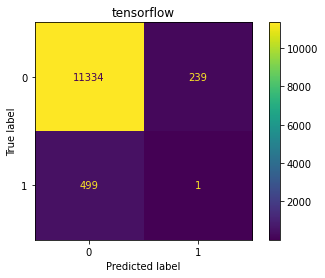

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, model_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("tensorflow")
plt.show()

In [ ]:
print('Accuracy:', accuracy_score(test_labels, result))
print('Precision:', precision_score(test_labels, result))
print('F1:', f1_score(test_labels, result))
print('Recall:', recall_score(test_labels, result))

Accuracy: 0.8
Precision: 1.0
F1: 0.888888888888889
Recall: 0.8


In [ ]:
words.columns

Index(['word', 'tag', 'frequency', 'doc_frequency'], dtype='object')

In [ ]:
set_words = set([str(word).lower() for word in words["word"].tolist()])

In [ ]:
len(set_words)

364355

In [ ]:
text = data['content'][0]

In [ ]:
text = text[text.index(";"):]

In [ ]:
patt = '[a-z]*n t '
groups = re.findall(patt, text)
groups

['couldn t ', 'couldn t ', 'won t ', 'can t ', 'don t ', 'don t ']

In [ ]:
def FixNotContraction(text):
  return text.replace(" ", "'") + " "

In [ ]:
for group in set(groups):
  text = text.replace(group, FixNotContraction(group.strip()))

In [ ]:
contractions.fix(text)

' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just could not wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he could not do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like thi

In [ ]:
test = reals['text'].apply(lambda x : ' '.join(fix(x)))

In [ ]:
test = [text.lower() for text in test]

In [ ]:
test = [one_hot(text, voc_size) for text in test]

In [ ]:
test = pad_sequences(test, padding="pre", maxlen=sent_len)

In [ ]:
result = model.predict(numpy.array(test))